Loaded manual segmentation with shape: (1129, 1129)
Extracted 106 manual outlines
Loading Xenium data from: G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738\cells.zarr.zip
Found polygon sets with keys: ['0', '1']
Loaded 13921 polygons from Xenium data
Filtered to 107 xenium polygons within the specified region
Scaled 107 xenium outlines to match manual segmentation
Converting 106 manual outlines and 107 xenium outlines to masks...
Computing centroids for matching...
Building KD-Tree with 107 xenium centroids...
Matching segmentations and calculating metrics...
Found 61 matches in 3.23 seconds
Number of matched segmentations: 61
Average IoU: 0.6659
Average Precision: 0.8804
Average Recall: 0.7446
Average Dice Loss: 0.2040
COCO-style mAP: 0.2142


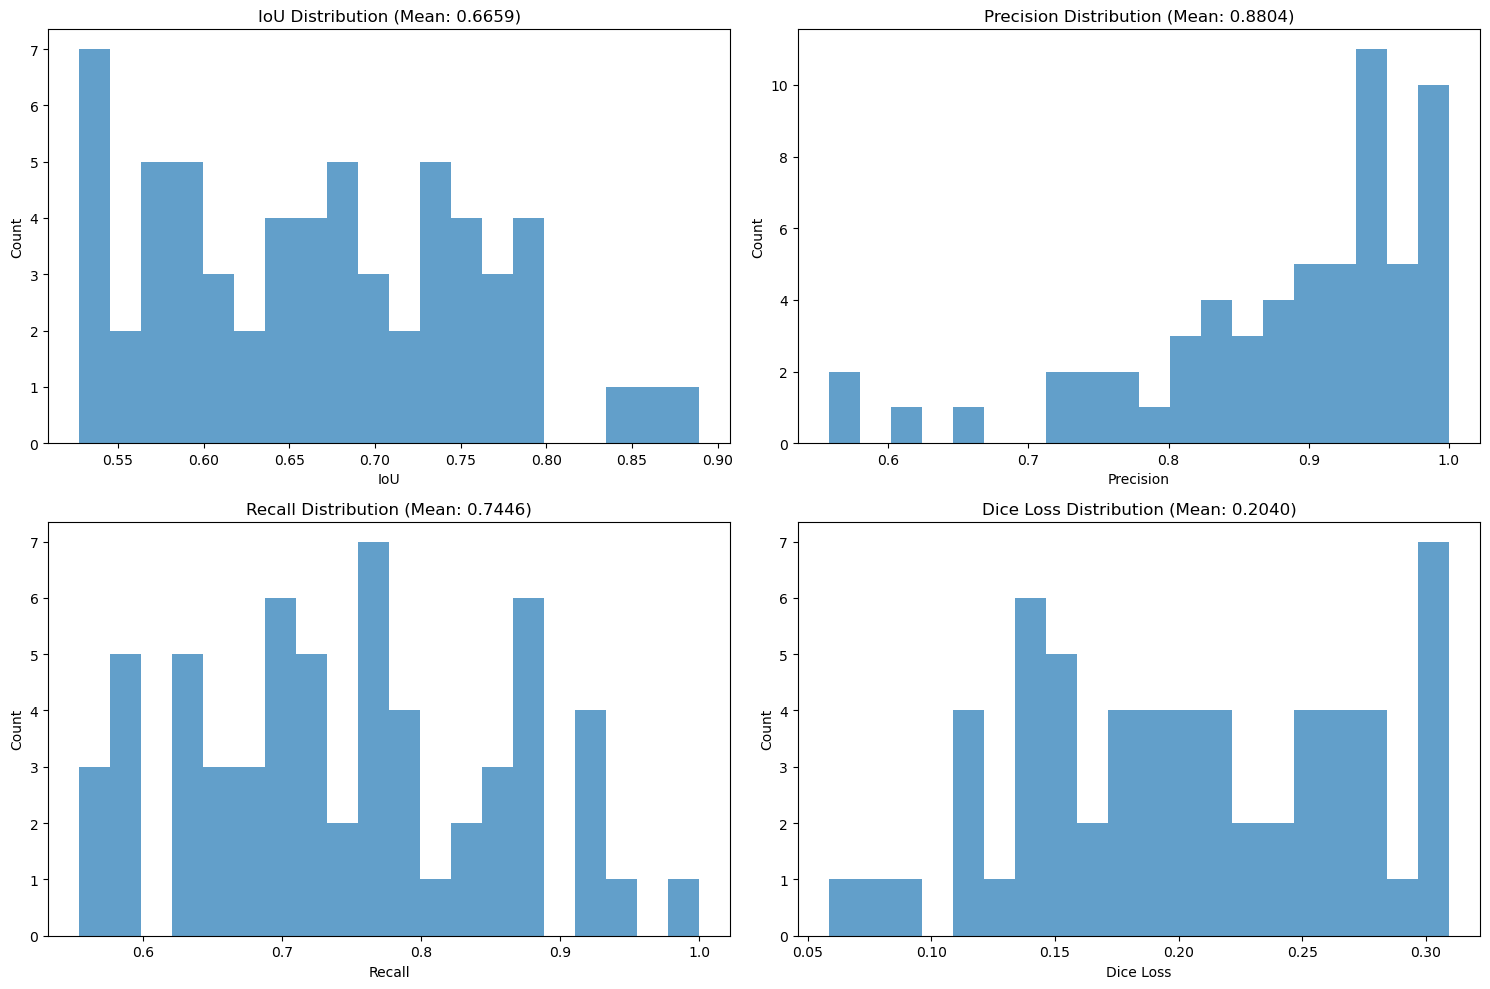

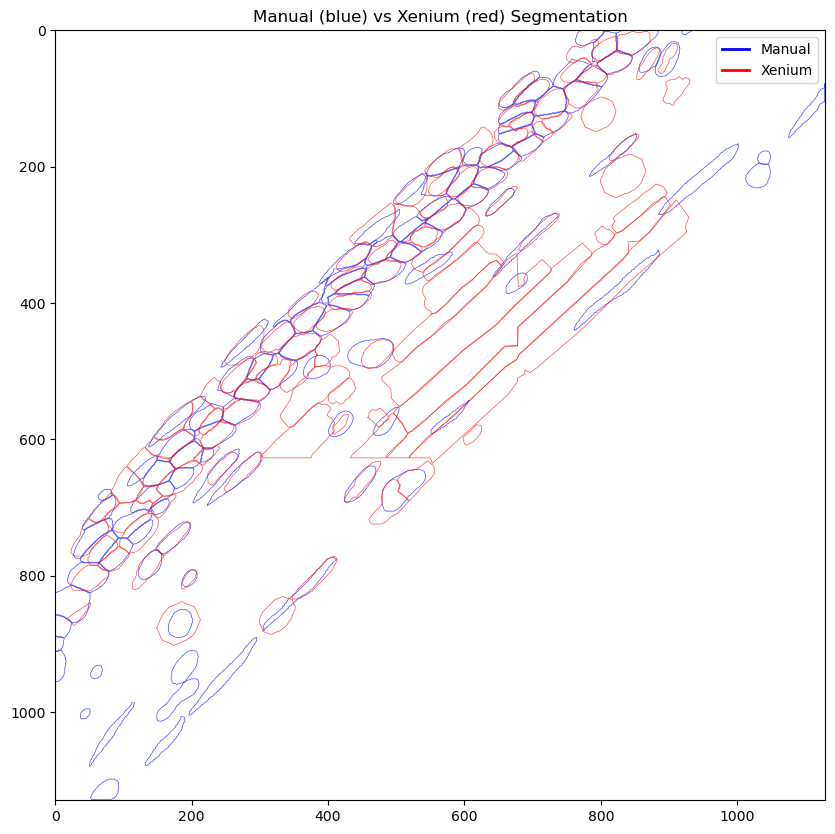

In [14]:
"""
Segmentation Comparison Script

This script compares two segmentation masks (manual and Xenium) and calculates
IoU, precision, recall, and Dice loss metrics.

Requirements:
- numpy
- matplotlib
- skimage
- cellpose
- scipy
- h5py
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from skimage.draw import polygon2mask
from cellpose import utils
from scipy.spatial import cKDTree
import os
import time
import zarr

def outline_to_mask(outline, shape):
    """Convert an outline to a binary mask"""
    return polygon2mask(shape, outline)

def calculate_iou(mask1, mask2):
    """Calculate Intersection over Union"""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def calculate_precision_recall(pred_mask, gt_mask):
    """Calculate precision and recall"""
    true_positive = np.logical_and(pred_mask, gt_mask).sum()
    false_positive = np.logical_and(pred_mask, np.logical_not(gt_mask)).sum()
    false_negative = np.logical_and(np.logical_not(pred_mask), gt_mask).sum()
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    return precision, recall

def calculate_dice_coefficient(mask1, mask2):
    """Calculate Dice coefficient"""
    intersection = np.logical_and(mask1, mask2).sum()
    total = mask1.sum() + mask2.sum()
    return 2 * intersection / total if total > 0 else 0

def calculate_dice_loss(mask1, mask2):
    """Calculate Dice loss"""
    return 1 - calculate_dice_coefficient(mask1, mask2)

def simple_match_segmentations(manual_outlines, xenium_outlines, image_shape):
    """A simpler matching approach without KD-Tree (for small datasets or debugging)"""
    print("Using simple matching approach (without KD-Tree)...")
    
    # Safety check
    if len(manual_outlines) == 0 or len(xenium_outlines) == 0:
        print("ERROR: One or both outline lists are empty. Cannot perform matching.")
        return [], [], [], [], []
    
    # Convert all outlines to masks
    print(f"Converting {len(manual_outlines)} manual outlines and {len(xenium_outlines)} xenium outlines to masks...")
    manual_masks = [outline_to_mask(outline, image_shape) for outline in manual_outlines]
    xenium_masks = [outline_to_mask(outline, image_shape) for outline in xenium_outlines]
    
    # Store matches and metrics
    matches = []
    ious = []
    precisions = []
    recalls = []
    dice_losses = []
    
    print("Matching segmentations using brute force approach...")
    start_time = time.time()
    
    # Set IoU threshold for considering a match
    iou_threshold = 0.5
    
    # For each manual segmentation, find the best matching xenium segmentation
    for i, manual_mask in enumerate(manual_masks):
        best_iou = 0
        best_match = -1
        
        # Check against all xenium segmentations (this is the brute force part)
        for j, xenium_mask in enumerate(xenium_masks):
            iou = calculate_iou(manual_mask, xenium_mask)
            
            if iou > best_iou:
                best_iou = iou
                best_match = j
        
        # Only include matches above the threshold
        if best_iou > iou_threshold and best_match != -1:
            matches.append((i, best_match))
            ious.append(best_iou)
            
            # Calculate additional metrics for the best match
            precision, recall = calculate_precision_recall(xenium_masks[best_match], manual_mask)
            dice_loss = calculate_dice_loss(xenium_masks[best_match], manual_mask)
            
            precisions.append(precision)
            recalls.append(recall)
            dice_losses.append(dice_loss)
    
    elapsed_time = time.time() - start_time
    print(f"Found {len(matches)} matches in {elapsed_time:.2f} seconds")
    
    return matches, ious, precisions, recalls, dice_losses

def match_segmentations(manual_outlines, xenium_outlines, image_shape):
    """Match segmentations based on IoU using KD-Tree for efficiency"""
    # Safety check - if either list is empty, return empty results
    if len(manual_outlines) == 0 or len(xenium_outlines) == 0:
        print("ERROR: One or both outline lists are empty. Cannot perform matching.")
        return [], [], [], [], []
    
    print(f"Converting {len(manual_outlines)} manual outlines and {len(xenium_outlines)} xenium outlines to masks...")
    
    # Convert all outlines to masks
    manual_masks = [outline_to_mask(outline, image_shape) for outline in manual_outlines]
    xenium_masks = [outline_to_mask(outline, image_shape) for outline in xenium_outlines]
    
    print("Computing centroids for matching...")
    # Compute centroids for more efficient matching
    manual_centroids = []
    for outline in manual_outlines:
        centroid = np.mean(outline, axis=0)
        manual_centroids.append(centroid)
    
    xenium_centroids = []
    for outline in xenium_outlines:
        centroid = np.mean(outline, axis=0)
        xenium_centroids.append(centroid)
    
    # Build KD-Tree for efficient nearest neighbor search
    print(f"Building KD-Tree with {len(xenium_centroids)} xenium centroids...")
    tree = cKDTree(np.array(xenium_centroids))
    
    # Store matches and metrics
    matches = []
    ious = []
    precisions = []
    recalls = []
    dice_losses = []
    
    print("Matching segmentations and calculating metrics...")
    start_time = time.time()
    
    # For each manual segmentation, find the best matching xenium segmentation
    for i, manual_centroid in enumerate(manual_centroids):
        # Find k nearest neighbors (or fewer if not enough points)
        k = min(5, len(xenium_centroids))
        distances, indices = tree.query(manual_centroid, k=k)
        
        best_iou = 0
        best_match = -1
        best_precision = 0
        best_recall = 0
        best_dice_loss = 1
        
        # Check IoU with each neighbor
        for idx in indices:
            iou = calculate_iou(manual_masks[i], xenium_masks[idx])
            if iou > best_iou:
                best_iou = iou
                best_match = idx
                # Calculate precision, recall, and dice loss for the best match
                precision, recall = calculate_precision_recall(xenium_masks[idx], manual_masks[i])
                dice_loss = calculate_dice_loss(xenium_masks[idx], manual_masks[i])
                best_precision = precision
                best_recall = recall
                best_dice_loss = dice_loss
        
        if best_match != -1 and best_iou > 0.5:  # Only include good matches
            matches.append((i, best_match))
            ious.append(best_iou)
            precisions.append(best_precision)
            recalls.append(best_recall)
            dice_losses.append(best_dice_loss)
    
    elapsed_time = time.time() - start_time
    print(f"Found {len(matches)} matches in {elapsed_time:.2f} seconds")
    return matches, ious, precisions, recalls, dice_losses

def main():
    # 1. Load manual segmentation
    manual_data_path = r"G:/Alexis_data/ST/Calculation_5k/Manual_cropped_square_com_6_seg.npy"
    manual_data = np.load(manual_data_path, allow_pickle=True)
    manual_masks = manual_data.item()['masks'] if isinstance(manual_data.item(), dict) else manual_data
    
    print(f"Loaded manual segmentation with shape: {manual_masks.shape}")
    
    # Extract outlines
    manual_outlines = utils.outlines_list(manual_masks)
    print(f"Extracted {len(manual_outlines)} manual outlines")
    
    # 2. Load xenium segmentation using zarr format
    # Define the crop region parameters
    start_x = 644.5124999999999
    start_y = 736.9499999999999
    x_min, x_max = start_x, start_x + 200
    y_min, y_max = start_y, start_y + 200
    
    # Path to the zarr file containing polygon sets
    xenium_path = r"G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738\cells.zarr.zip"
    
    try:
        # Function to open a Zarr file
        def open_zarr(path):
            store = zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path)
            return zarr.group(store=store)
        
        # Load the xenium data
        print(f"Loading Xenium data from: {xenium_path}")
        root = open_zarr(xenium_path)
        
        # Access polygon sets
        polygon_sets = root["polygon_sets"]
        print(f"Found polygon sets with keys: {list(polygon_sets.keys())}")
        
        # Access the polygon set (use '1' or '0' as needed)
        polygon_set = polygon_sets['1']  # Try '0' if this fails
        
        # Load data arrays
        num_vertices = polygon_set['num_vertices'][:]
        vertices = polygon_set['vertices'][:]
        
        print(f"Loaded {len(num_vertices)} polygons from Xenium data")
        
        # Collect polygons
        all_polygons = []
        
        for i in range(len(num_vertices)):
            n_vertices = num_vertices[i]
            if n_vertices < 3:
                continue  # Skip if not enough vertices to form a polygon
        
            # Extract x and y coordinates
            vertex_row = vertices[i, :2 * n_vertices]
            x_coords = vertex_row[::2]
            y_coords = vertex_row[1::2]
        
            # Check if the polygon is within the crop bounds
            if (x_coords.min() >= x_min and x_coords.max() <= x_max and
                y_coords.min() >= y_min and y_coords.max() <= y_max):
                
                # Close the polygon by appending the first point to the end
                x_coords = np.append(x_coords, x_coords[0])
                y_coords = np.append(y_coords, y_coords[0])
        
                # Combine x and y into coordinates
                polygon_coords = np.column_stack((x_coords, y_coords))
                all_polygons.append(polygon_coords)
        
        print(f"Filtered to {len(all_polygons)} xenium polygons within the specified region")
        
    except Exception as e:
        print(f"Failed to load xenium data: {e}")
        # Generate some random polygons for testing if we don't have real data
        print("WARNING: Using randomly generated test polygons instead of Xenium data")
        # Create some random polygons similar to the manual ones
        all_polygons = []
        for outline in manual_outlines:
            # Create a slightly modified version of the manual outline
            noise = np.random.normal(0, 5, outline.shape)
            test_polygon = outline + noise
            all_polygons.append(test_polygon)
    
    # 3. Scale xenium segmentation to match manual segmentation
    image_shape = manual_masks.shape
    
    # Scaling factors to map the original coordinates to manual segmentation space
    scale_x = 200/0.2125 / (x_max - x_min)
    scale_y = 200/0.2125 / (y_max - y_min)
    
    scaled_xenium_outlines = []
    for polygon_coords in all_polygons:
        # Separate x and y coordinates
        x_coords = polygon_coords[:, 0]
        y_coords = polygon_coords[:, 1]
        
        # Apply the scaling transformation
        x_coords_scaled = ((x_coords - x_min) * scale_x)
        y_coords_scaled = ((y_coords - y_min) * scale_y)
        
        # Combine scaled x and y coordinates back into a single array
        scaled_polygon_coords = np.column_stack((x_coords_scaled, y_coords_scaled))
        
        # Append the scaled polygon to the new list
        scaled_xenium_outlines.append(scaled_polygon_coords)
    
    print(f"Scaled {len(scaled_xenium_outlines)} xenium outlines to match manual segmentation")
    
    # 4. Match segmentations and calculate metrics
    # You can use the KD-Tree method (faster for large datasets)
    matches, ious, precisions, recalls, dice_losses = match_segmentations(
        manual_outlines, scaled_xenium_outlines, image_shape
    )
    
    # Alternative: Uncomment the following to use a simple matching approach without KD-Tree
    # This is slower but simpler and may be more robust for small datasets
    # matches, ious, precisions, recalls, dice_losses = simple_match_segmentations(
    #     manual_outlines, scaled_xenium_outlines, image_shape
    # )
    
    # 5. Visualize results
    plt.figure(figsize=(10, 10))
    
    # Plot manual segmentation in blue
    manual_lc = LineCollection([np.vstack([o, o[0]]) for o in manual_outlines], 
                               colors='blue', linewidths=0.5, alpha=0.7, label='Manual')
    plt.gca().add_collection(manual_lc)
    
    # Plot xenium segmentation in red
    xenium_lc = LineCollection([np.vstack([o, o[0]]) for o in scaled_xenium_outlines], 
                               colors='red', linewidths=0.5, alpha=0.7, label='Xenium')
    plt.gca().add_collection(xenium_lc)
    
    # Add a custom legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='blue', lw=2),
                   Line2D([0], [0], color='red', lw=2)]
    plt.legend(custom_lines, ['Manual', 'Xenium'])
    
    plt.xlim(0, image_shape[1])
    plt.ylim(image_shape[0], 0)  # Invert y-axis
    plt.gca().set_aspect('equal')
    plt.grid(False)
    plt.title('Manual (blue) vs Xenium (red) Segmentation')
    
    # 6. Print metrics summary
    print(f"Number of matched segmentations: {len(matches)}")
    print(f"Average IoU: {np.mean(ious):.4f}")
    print(f"Average Precision: {np.mean(precisions):.4f}")
    print(f"Average Recall: {np.mean(recalls):.4f}")
    print(f"Average Dice Loss: {np.mean(dice_losses):.4f}")
    
    # 7. Calculate COCO-style metrics
    # In COCO evaluation, we typically calculate mean metrics at various IoU thresholds
    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    
    # Calculate mAP (mean Average Precision) at different IoU thresholds
    ap_per_threshold = []
    for threshold in iou_thresholds:
        matches_at_threshold = sum(1 for iou in ious if iou >= threshold)
        precision_at_threshold = matches_at_threshold / len(manual_outlines) if len(manual_outlines) > 0 else 0
        ap_per_threshold.append(precision_at_threshold)
    
    mean_ap = np.mean(ap_per_threshold)
    print(f"COCO-style mAP: {mean_ap:.4f}")
    
    # 8. Save detailed metrics to CSV
    metrics_df = np.column_stack((
        [m[0] for m in matches],  # Manual segmentation index
        [m[1] for m in matches],  # Xenium segmentation index
        ious,
        precisions,
        recalls,
        dice_losses
    ))
    
    np.savetxt(
        'segmentation_metrics.csv',
        metrics_df,
        delimiter=',',
        header='manual_idx,xenium_idx,iou,precision,recall,dice_loss',
        comments=''
    )
    
    # 9. Plot histograms of metrics
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(ious, bins=20, alpha=0.7)
    plt.title(f'IoU Distribution (Mean: {np.mean(ious):.4f})')
    plt.xlabel('IoU')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 2)
    plt.hist(precisions, bins=20, alpha=0.7)
    plt.title(f'Precision Distribution (Mean: {np.mean(precisions):.4f})')
    plt.xlabel('Precision')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 3)
    plt.hist(recalls, bins=20, alpha=0.7)
    plt.title(f'Recall Distribution (Mean: {np.mean(recalls):.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Count')
    
    plt.subplot(2, 2, 4)
    plt.hist(dice_losses, bins=20, alpha=0.7)
    plt.title(f'Dice Loss Distribution (Mean: {np.mean(dice_losses):.4f})')
    plt.xlabel('Dice Loss')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('segmentation_metrics_histograms.png', dpi=300)
    
    # Save the first plot
    plt.figure(1)
    plt.savefig('segmentation_comparison.png', dpi=300)
    
    # Show all plots
    plt.show()

if __name__ == "__main__":
    main()

Loaded manual segmentation with shape: (1129, 1129)


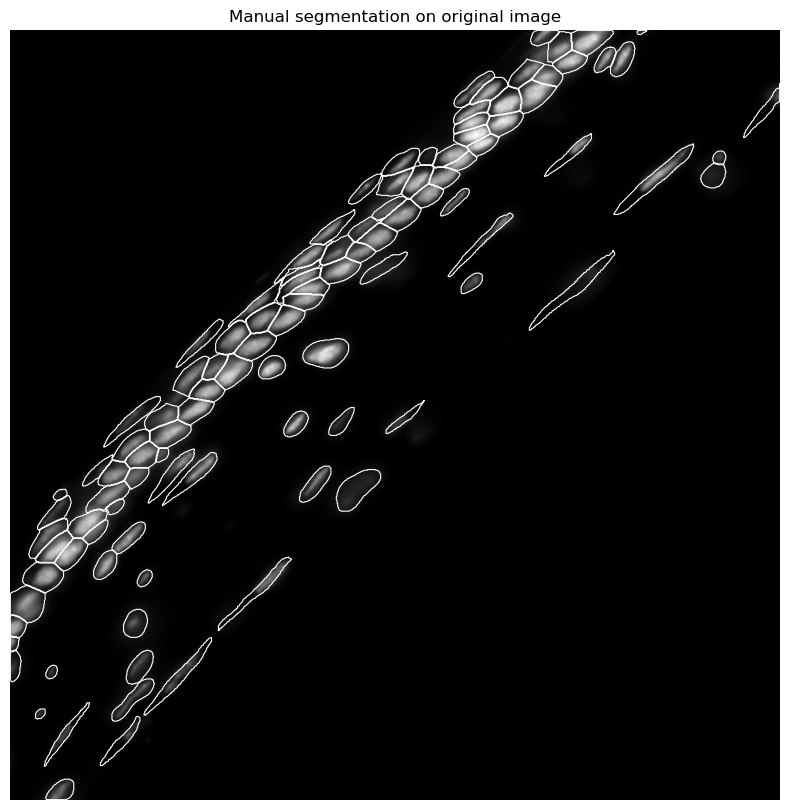

In [26]:
# ------------------------------------------------------------
# 0. imports
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from skimage.io import imread, imsave
from cellpose import utils          # pip install cellpose

# ------------------------------------------------------------
# 1. load original image (grayscale or RGB)
# ------------------------------------------------------------
orig_2c = imread(r"G:\Alexis_data\ST\Calculation_5k\merged_square_com_6.tif")

orig = orig_2c[0]   

# ------------------------------------------------------------
# 2. get manual outlines (one numpy (N,2) array per cell)
# ------------------------------------------------------------
manual_data_path = r"G:/Alexis_data/ST/Calculation_5k/Manual_cropped_square_com_6_seg.npy"
manual_data = np.load(manual_data_path, allow_pickle=True)
manual_masks = manual_data.item()['masks'] if isinstance(manual_data.item(), dict) else manual_data

print(f"Loaded manual segmentation with shape: {manual_masks.shape}")

# Extract outlines
manual_outlines = utils.outlines_list(manual_masks)

# ------------------------------------------------------------
# 3. plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(orig, cmap='gray')         # show the raw image

# white outlines, slightly thicker to stand out
outline_lc = LineCollection(
    [np.vstack([o, o[0]]) for o in manual_outlines],   # close each loop
    colors='white', linewidths=0.8
)
ax.add_collection(outline_lc)

ax.set_axis_off()
ax.set_title('Manual segmentation on original image')

# ------------------------------------------------------------
# 4. save the overlay (transparent background)
# ------------------------------------------------------------
# draw the canvas once to bake the artists into the figure
fig.canvas.draw()

# grab the RGBA buffer from the canvas and save as PNG
overlay_rgba = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
overlay_rgba = overlay_rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))
# matplotlib gives ARGB; convert to RGBA
overlay_rgba = overlay_rgba[:, :, [1,2,3,0]]

imsave('manual_overlay.png', overlay_rgba)   # PNG keeps alpha

plt.show()


Loading Xenium data from: G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738\cells.zarr.zip
Found polygon sets with keys: ['0', '1']
Loaded 13921 polygons from Xenium data
Filtered to 107 xenium polygons within the specified region


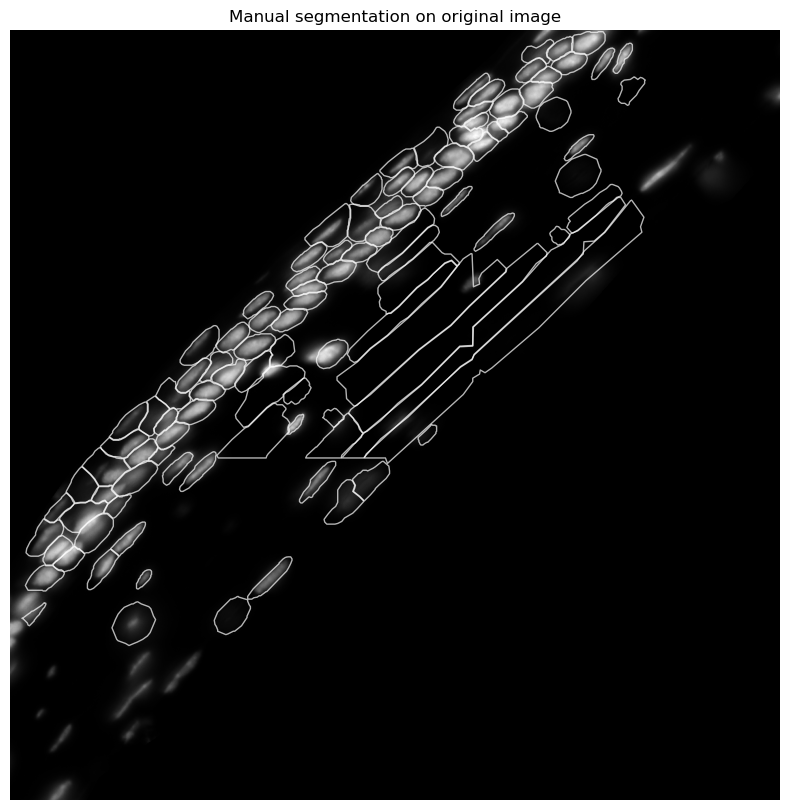

In [28]:
# ------------------------------------------------------------
# 0. imports
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from skimage.io import imread, imsave
from cellpose import utils          # pip install cellpose

# ------------------------------------------------------------
# 1. load original image (grayscale or RGB)
# ------------------------------------------------------------
orig_2c = imread(r"G:\Alexis_data\ST\Calculation_5k\merged_square_com_6.tif")

orig = orig_2c[0]   

# ------------------------------------------------------------
# 2. get Xenium outlines (one numpy (N,2) array per cell)
# ------------------------------------------------------------
# Path to the zarr file containing polygon sets
xenium_path = r"G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738\cells.zarr.zip"

start_x = 644.5124999999999
start_y = 736.9499999999999
x_min, x_max = start_x, start_x + 200
y_min, y_max = start_y, start_y + 200

# Function to open a Zarr file
def open_zarr(path):
    store = zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path)
    return zarr.group(store=store)

# Load the xenium data
print(f"Loading Xenium data from: {xenium_path}")
root = open_zarr(xenium_path)

# Access polygon sets
polygon_sets = root["polygon_sets"]
print(f"Found polygon sets with keys: {list(polygon_sets.keys())}")

# Access the polygon set (use '1' or '0' as needed)
polygon_set = polygon_sets['1']  # Try '0' if this fails

# Load data arrays
num_vertices = polygon_set['num_vertices'][:]
vertices = polygon_set['vertices'][:]

print(f"Loaded {len(num_vertices)} polygons from Xenium data")

# Collect polygons
all_polygons = []

for i in range(len(num_vertices)):
    n_vertices = num_vertices[i]
    if n_vertices < 3:
        continue  # Skip if not enough vertices to form a polygon

    # Extract x and y coordinates
    vertex_row = vertices[i, :2 * n_vertices]
    x_coords = vertex_row[::2]
    y_coords = vertex_row[1::2]

    # Check if the polygon is within the crop bounds
    if (x_coords.min() >= x_min and x_coords.max() <= x_max and
        y_coords.min() >= y_min and y_coords.max() <= y_max):
        
        # Close the polygon by appending the first point to the end
        x_coords = np.append(x_coords, x_coords[0])
        y_coords = np.append(y_coords, y_coords[0])

        # Combine x and y into coordinates
        polygon_coords = np.column_stack((x_coords, y_coords))
        all_polygons.append(polygon_coords)

print(f"Filtered to {len(all_polygons)} xenium polygons within the specified region")

# 3. Scale xenium segmentation to match manual segmentation
image_shape = manual_masks.shape

# Scaling factors to map the original coordinates to manual segmentation space
scale_x = 200/0.2125 / (x_max - x_min)
scale_y = 200/0.2125 / (y_max - y_min)

scaled_xenium_outlines = []
for polygon_coords in all_polygons:
    # Separate x and y coordinates
    x_coords = polygon_coords[:, 0]
    y_coords = polygon_coords[:, 1]
    
    # Apply the scaling transformation
    x_coords_scaled = ((x_coords - x_min) * scale_x)
    y_coords_scaled = ((y_coords - y_min) * scale_y)
    
    # Combine scaled x and y coordinates back into a single array
    scaled_polygon_coords = np.column_stack((x_coords_scaled, y_coords_scaled))
    
    # Append the scaled polygon to the new list
    scaled_xenium_outlines.append(scaled_polygon_coords)




fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(orig, cmap='gray')         # show the raw image

# white outlines, slightly thicker to stand out
xenium_lc = LineCollection([np.vstack([o, o[0]]) for o in scaled_xenium_outlines], 
                            colors='white', linewidths=1, alpha=0.7, label='Xenium')

ax.add_collection(xenium_lc)

ax.set_axis_off()
ax.set_title('Manual segmentation on original image')

# ------------------------------------------------------------
# 4. save the overlay (transparent background)
# ------------------------------------------------------------
# draw the canvas once to bake the artists into the figure
fig.canvas.draw()

# grab the RGBA buffer from the canvas and save as PNG
overlay_rgba = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
overlay_rgba = overlay_rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))
# matplotlib gives ARGB; convert to RGBA
overlay_rgba = overlay_rgba[:, :, [1,2,3,0]]

imsave('Xenium_overlay.png', overlay_rgba)   # PNG keeps alpha

plt.show()


In [9]:
"""
Simple script to:
1. Read Xenium boundaries
2. Connect them into outlines
3. Convert outlines to pixels
4. Save as TIFF image
"""

import numpy as np
import zarr
from skimage.io import imsave
from skimage.draw import line

# Function to open a Zarr file
def open_zarr(path):
    store = zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path)
    return zarr.group(store=store)

# Create an output image from outlines
def outlines_to_image(outlines, shape):
    # Create empty image
    image = np.zeros(shape, dtype=np.uint8)
    
    # Draw each outline
    for outline in outlines:
        # Close the outline
        closed_outline = np.vstack([outline, outline[0:1]])
        
        # Draw line segments
        for i in range(len(closed_outline) - 1):
            rr, cc = line(
                int(round(closed_outline[i, 1])),   # y-coordinate for row
                int(round(closed_outline[i, 0])),   # x-coordinate for column
                int(round(closed_outline[i+1, 1])), # next y-coordinate
                int(round(closed_outline[i+1, 0]))  # next x-coordinate
            )
            
            # Make sure indices are within bounds
            valid = (rr >= 0) & (rr < shape[0]) & (cc >= 0) & (cc < shape[1])
            if np.any(valid):
                # Set boundary pixels to white (255)
                image[rr[valid], cc[valid]] = 255
                
    return image

# Main execution
# Path to the zarr file
xenium_path = r"G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738\cells.zarr.zip"

# Define the crop region
start_x = 644.5124999999999
start_y = 736.9499999999999
x_min, x_max = start_x, start_x + 200
y_min, y_max = start_y, start_y + 200

# Load Xenium data
root = open_zarr(xenium_path)
polygon_sets = root["polygon_sets"]
polygon_set = polygon_sets['1']  # Use '0' if this doesn't work

# Extract polygon data
num_vertices = polygon_set['num_vertices'][:]
vertices = polygon_set['vertices'][:]

# Collect polygons in the specified region
xenium_outlines = []
for i in range(len(num_vertices)):
    n_vertices = num_vertices[i]
    if n_vertices < 3:
        continue
    
    # Extract coordinates
    vertex_row = vertices[i, :2 * n_vertices]
    x_coords = vertex_row[::2]
    y_coords = vertex_row[1::2]
    
    # Check if in the region
    if (x_coords.min() >= x_min and x_coords.max() <= x_max and
        y_coords.min() >= y_min and y_coords.max() <= y_max):
        
        # Scale coordinates to image space
        x_coords_scaled = ((x_coords - x_min) * (200/0.2125 / (x_max - x_min)))
        y_coords_scaled = ((y_coords - y_min) * (200/0.2125 / (y_max - y_min)))
        
        # Create outline
        outline = np.column_stack((x_coords_scaled, y_coords_scaled))
        xenium_outlines.append(outline)

print(f"Found {len(xenium_outlines)} Xenium outlines")

# Create the image (use appropriate dimensions)
image_shape = (942, 942)  # Adjust size as needed
boundary_image = outlines_to_image(xenium_outlines, image_shape)

# Save as TIFF
output_path = r"G:\Alexis_data\Project\SpatialOmics_cellpose\img\xenium_boundaries.tif"
imsave(output_path, boundary_image)

print(f"Saved boundary image to {output_path}")

Found 107 Xenium outlines
Saved boundary image to G:\Alexis_data\Project\SpatialOmics_cellpose\img\xenium_boundaries.tif


In [10]:
# --- parameters ---------------------------------------------------
TARGET_SIDE = 1129            # final width = height = 1129 px
image_shape = (TARGET_SIDE, TARGET_SIDE)

# pre-compute scale factors once
scale_x = (TARGET_SIDE - 1) / (x_max - x_min)
scale_y = (TARGET_SIDE - 1) / (y_max - y_min)

# --- collect outlines --------------------------------------------
xenium_outlines = []
for i, n_vertices in enumerate(num_vertices):
    if n_vertices < 3:
        continue

    row = vertices[i, :2 * n_vertices]
    x_coords = row[::2]
    y_coords = row[1::2]

    in_crop = (
        x_coords.min() >= x_min and x_coords.max() <= x_max and
        y_coords.min() >= y_min and y_coords.max() <= y_max
    )
    if not in_crop:
        continue

    # --- scale into image space -----------------------------------
    x_scaled = np.round((x_coords - x_min) * scale_x).astype(int)
    y_scaled = np.round((y_coords - y_min) * scale_y).astype(int)

    # safety clamp (handles any rounding spill)
    np.clip(x_scaled, 0, TARGET_SIDE - 1, out=x_scaled)
    np.clip(y_scaled, 0, TARGET_SIDE - 1, out=y_scaled)

    xenium_outlines.append(np.column_stack((x_scaled, y_scaled)))

print(f"Found {len(xenium_outlines)} Xenium outlines")

# --- rasterise & save --------------------------------------------
boundary_image = outlines_to_image(xenium_outlines, image_shape)
imsave(r"G:\Alexis_data\Project\SpatialOmics_cellpose\img\xenium_boundaries_1129.tif",
       boundary_image)
print("Saved 1129 × 1129 boundary image")


Found 107 Xenium outlines
Saved 1129 × 1129 boundary image


In [11]:
# ------------------------------------------------------------
# 1. boundary_image == 255 on the outlines, 0 elsewhere
# ------------------------------------------------------------
mask = boundary_image                 # shape (1129, 1129), uint8

# ------------------------------------------------------------
# 2. build an RGBA array
#    – start fully transparent (all zeros)
#    – wherever mask==255, set RGB = 255 (white) and A = 255
# ------------------------------------------------------------
rgba = np.zeros((*mask.shape, 4), dtype=np.uint8)     # Y, X, Samples
rgba[mask == 255, 0:3] = 255        # R,G,B → white
rgba[mask == 255, 3]   = 255        # A     → opaque

# ------------------------------------------------------------
# 3a. save as TIFF with alpha (4-sample RGBA)
# ------------------------------------------------------------
from tifffile import imwrite
imwrite(r"G:\Alexis_data\Project\SpatialOmics_cellpose\img\xenium_boundaries_1129_rgba.tif",
        rgba, photometric='rgb')     # Fiji reads this with transparency

# ------------------------------------------------------------
# 3b. OR save as PNG if you prefer
# ------------------------------------------------------------
# import imageio.v3 as iio
# iio.imwrite(r"...\xenium_boundaries_1129_rgba.png", rgba)

print("Saved RGBA image with transparent background 🚀")


Saved RGBA image with transparent background 🚀
